# 1. Import libraries

In [111]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load and pre-process the dataset

In [112]:
data_dir ='data'
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')

print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [113]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.
np.random.seed(seed=42)
def add_noise(img):
    std_coeff = 70*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

image_res = 30
def get_images(train_dir: str, test_dir: str):
    datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

    img_height, img_width = image_res, image_res
    batch_size = 32

    # Load training data
    train_data = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        color_mode='grayscale'
    )

    # Load test data
    test_data = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        color_mode='grayscale'
    )

    return train_data, test_data

# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# 3. Visualise data and plot data distribution

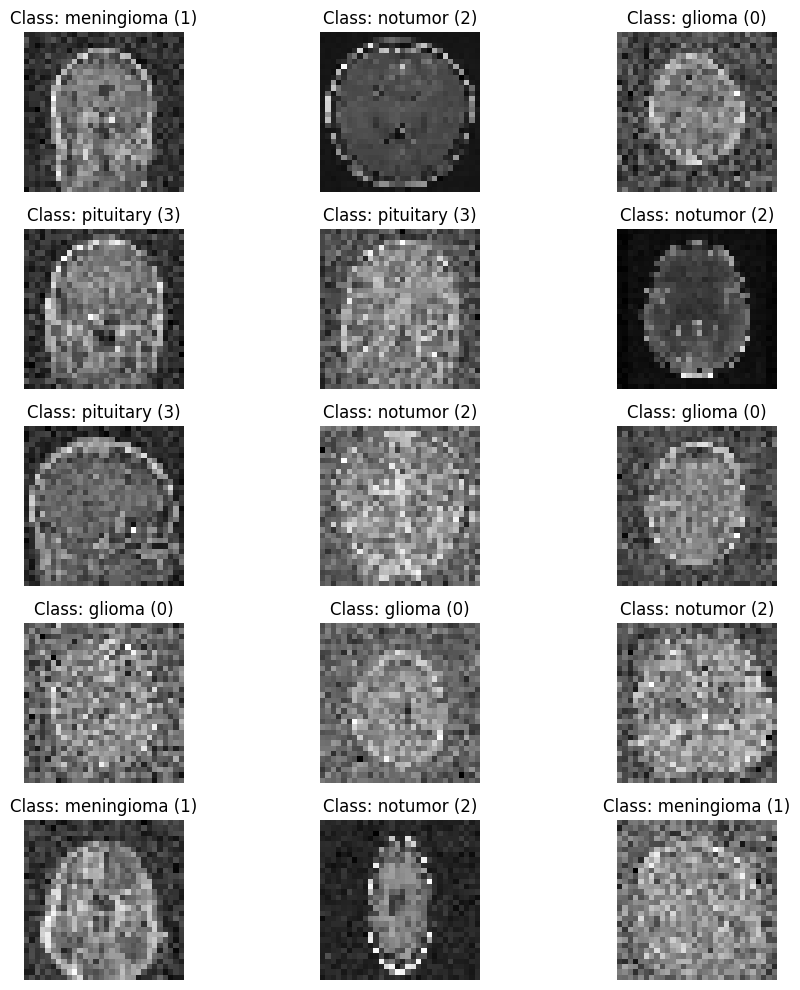

In [114]:
def visualize_batch(df): 

    #Iterating through the different batches
    image_batch, label_batch = next(df)

    #Deriving the class names
    class_names = train_data.class_indices

    #Creating 1 figure with 15 subplots
    fig, ax = plt.subplots(nrows= 5, ncols = 3, figsize = (10, 10))

    #Flatten the axis allowing for easier assignment of 'i'
    ax = ax.flatten()
    for i in range(15): 
        
        #For every ax[i], display the image on the index
        ax[i].imshow(image_batch[i], cmap = 'grey')
        ax[i].axis('off')
        
        #Deriving the class number and class name
        class_number = label_batch[i].argmax()
        
        #Displaying the class name and its corresponding number
        for name, number in class_names.items(): 
            
            #Checking which number corresponds to the class number
            if number == class_number: 
                class_name = name
                ax[i].set_title(f'Class: {class_name} ({class_number})')

    plt.tight_layout()
    plt.show()
    
visualize_batch(train_data)


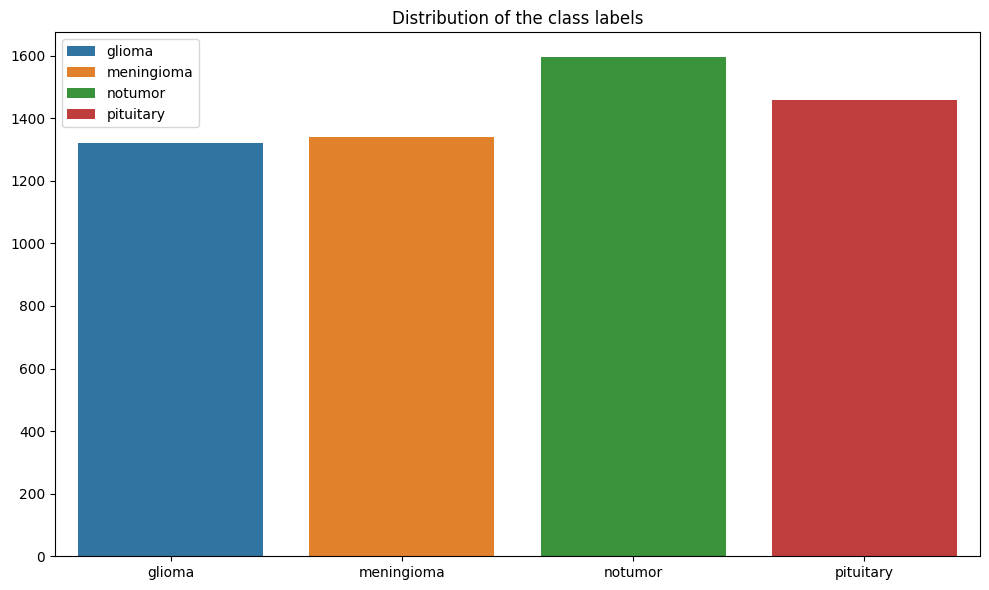

In [115]:
def plot_distribution(df):
    #Resetting the generator for consistent results
    df.reset()
    
    #Deriving the number of batches and classes
    n_batches = df.num_batches
    n_classes = df.num_classes
    class_names = list(df.class_indices.keys())
    total_samples = df.samples
    
    
    #Setting an emtpy array. Here the count of classes will be stored
    classes = np.zeros((1, n_classes))

    #Iterating over the batches and summing them, adding them to the np.zeros classes document 
    for i in range(n_batches): 
        x, y = next(df)
        sum_y = np.sum(y, axis = 0)
        classes += sum_y
    
    #Flattening the data so they can be plotted
    classes = classes.astype(int).flatten()
    
    #Testing if the sum of the classes aligns with the total samples in the train set.
    #If this it does not align, we made a mistake in coding
    assert np.sum(classes) == total_samples
    
    plt.figure(figsize = (10, 6))
    sns.barplot(x = class_names, y = classes, estimator = np.sum, hue = class_names, legend= True)
    plt.title('Distribution of the class labels')
    plt.tight_layout()
    plt.show()
    
        
plot_distribution(train_data)


# 4. Train and Evaluation functions

In [130]:
from keras import Sequential, Input, layers
def baseline():
    baseline = Sequential()
    baseline.add(Input(shape = (30, 30, 1)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Conv2D(32, (3, 3), activation = "relu"))
    baseline.add(layers.MaxPooling2D((2, 2)))
    baseline.add(layers.Flatten())
    baseline.add(layers.Dense(32, activation = "relu"))
    baseline.add(layers.Dense(4, activation = "softmax"))
    baseline.compile(optimizer = "adam", 
                    loss = 'categorical_crossentropy',
                    metrics = ["accuracy"])
    return baseline

In [126]:
# plot diagnostic learning curves
def summarize_loss(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Loss')
    plt.plot(range(1,len(history.history['loss']) + 1),history.history['loss'], color='red', label='Train loss')
    plt.plot(range(1,len(history.history['val_loss']) + 1),history.history['val_loss'], color='green', label='Validation loss')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, which='both', linestyle='-')
    val_loss = history.history['val_loss']
    best_epoch = val_loss.index(min(val_loss)) + 1
    plt.scatter(best_epoch, val_loss[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper right', fontsize='x-small')
    plt.show()
    return

def summarize_accuracy(history):
    plt.figure(figsize=(6, 4))
    plt.title('Baseline Model Training and Validation Accuracy')
    plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], color='red', label='Train accuracy')
    plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'], color='green', label='Validation accuracy')
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, which='both', linestyle='-')
    val_accuracy = history.history['val_accuracy']
    best_epoch = val_accuracy.index(max(val_accuracy)) + 1
    plt.scatter(best_epoch, val_accuracy[best_epoch - 1], color='blue', s=20, label=f'best epoch= {best_epoch}')
    plt.legend(loc='upper left', fontsize='x-small')
    plt.show()
    return



Number of training samples: 5712


{None, 'binary', 'categorical', 'input', 'sparse'}

# 5. Model training

# 6. Model evaluation